In [2]:
#!pip install -U imbalanced-learn
#!pip install catboost

In [15]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [4]:
# importation des données
data = pd.read_excel('/content/drive/Othercomputers/Mon ordinateur/DIT MASTER1 2022/MASTER 2/MEMOIRE/data/data/dataset_cleaned_statusCode_12022024.xlsx')

In [5]:
data = data.drop('createdAt', axis=1)
data.head()

,process,amount,phoneNumber,statusCode,canal,country,event,browser,ip,agregator
0,MOBILE,100,22952734444,INSUFFICIENT_BALANCE,Website,BJ,645a225c4744ee6479066772,Light Browser,104.28.217.116,MTNBJ
1,MOBILE,100,22967393349,SUCCESS,Website,BJ,645a225c4744ee6479066772,Light Browser,104.28.217.116,MTNBJ
2,MOBILE,100,22952734444,TRANSACTION_CANCEL,Website,BJ,645a225c4744ee6479066772,Light Browser,104.28.217.116,MTNBJ
3,MOBILE,100,22963522309,WAITING_CUSTOMER_PAYMENT,Website,BJ,645a225c4744ee6479066772,Light Browser,104.28.217.116,FPZ
4,MOBILE,100,22952734444,TRANSACTION_CANCEL,Website,BJ,645a225c4744ee6479066772,Light Browser,104.28.217.116,MTNBJ


In [6]:
data.shape

(60836, 10)

In [7]:
data['process'] = data['process'].astype('str')
data['statusCode'] = data['statusCode'].astype('str')
data['canal'] = data['canal'].astype('str')
data['country'] = data['country'].astype('str')
data['event'] = data['event'].astype('str')
data['browser'] = data['browser'].astype('str')
data['ip'] = data['ip'].astype('str')
data['agregator'] = data['agregator'].astype('str')

In [8]:
data_u = data

# LabelEncoder

In [9]:
# transformation des variables catégorielles en variables numériques

# Initialiser l'encodeur de label
label_encoder = LabelEncoder()

# Stocker les correspondances entre les valeurs originales et les valeurs encodées
encoding_mappings = {}

# Transformer chaque colonne catégorielle en variable numérique
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])
    encoding_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Applicattion SMOTE

In [10]:
# Séparer les fonctionnalités et les étiquettes
X = data.drop(columns=['statusCode'])
y = data['statusCode']

# Appliquer SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Afficher les nouvelles dimensions des données
print("Dimensions des données après SMOTE :")
print(X_resampled.shape, y_resampled.shape)


Dimensions des données après SMOTE :
(151670, 9) (151670,)


In [11]:
X_resampled.head()

,process,amount,phoneNumber,canal,country,event,browser,ip,agregator
0,1,100,22952734444,2,6,0,10,400,7
1,1,100,22967393349,2,6,0,10,400,7
2,1,100,22952734444,2,6,0,10,400,7
3,1,100,22963522309,2,6,0,10,400,3
4,1,100,22952734444,2,6,0,10,400,7


In [ ]:
y_resampled.head()

0    1
1    2
2    3
3    4
4    3
Name: statusCode, dtype: int64

In [ ]:
print("Nombre de classes 0 :", sum(y_resampled == 0))
print("Nombre de classes 1 :", sum(y_resampled == 1))
print("Nombre de classes 0 :", sum(y_resampled == 2))
print("Nombre de classes 1 :", sum(y_resampled == 3))
print("Nombre de classes 0 :", sum(y_resampled == 4))


Nombre de classes 0 : 30334
Nombre de classes 1 : 30334
Nombre de classes 0 : 30334
Nombre de classes 1 : 30334
Nombre de classes 0 : 30334


# Séparation des données en train et test

In [12]:
# Séparation en train (70%), test (20%) et validation (10%) en fonction de y (statusCode)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# Affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement (train) :", X_train.shape[0])
print("Taille de l'ensemble de test :", X_test.shape[0])
print("Taille de l'ensemble de validation :", X_val.shape[0])

Taille de l'ensemble d'entraînement (train) : 106169
Taille de l'ensemble de test : 30485
Taille de l'ensemble de validation : 15016


# RandomForestClassifier

In [13]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Créer un classificateur RandomForest
rf_classifier = RandomForestClassifier(random_state=42)

# Recherche par grille pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Utiliser le classificateur avec les meilleurs hyperparamètres pour prédire les données de test
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)


# Calculer l'exactitude
classification_rep = classification_report(y_test, y_pred)

print("\nClassification Report:\n", classification_rep)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Meilleurs hyperparamètres: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      6097
           1       0.66      0.74      0.70      6097
           2       0.62      0.58      0.60      6097
           3       0.64      0.55      0.59      6097
           4       0.84      0.90      0.87      6097

    accuracy                           0.74     30485
   macro avg       0.74      0.74      0.74     30485
weighted avg       0.74      0.74      0.74     30485



In [28]:
classification_df = pd.DataFrame(classification_rep).transpose()
classification_df

,precision,recall,f1-score,support
0,0.906766,0.936362,0.921327,6097.000000
1,0.664596,0.737084,0.698966,6097.000000
2,0.624867,0.577005,0.599983,6097.000000
3,0.643621,0.552731,0.594723,6097.000000
4,0.839659,0.903559,0.870438,6097.000000
accuracy,0.741348,0.741348,0.741348,0.741348
macro avg,0.735902,0.741348,0.737087,30485.000000
weighted avg,0.735902,0.741348,0.737087,30485.000000


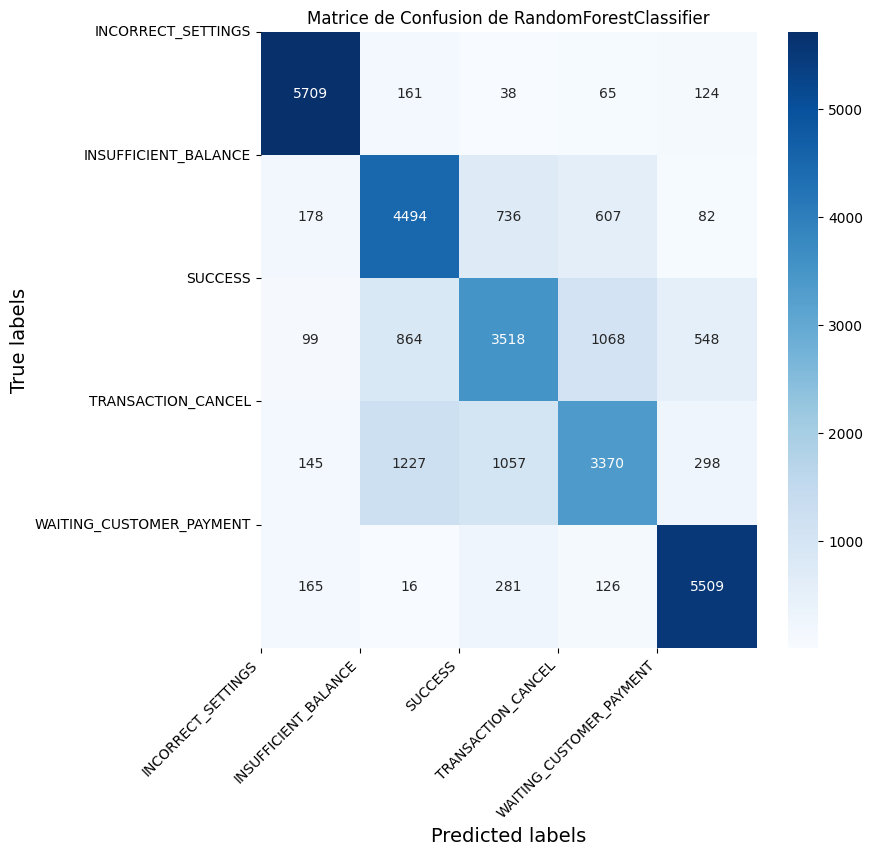

In [17]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une figure et un axe
fig, ax = plt.subplots(figsize=(8, 8))

# Afficher la matrice de confusion en utilisant une heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Définir les étiquettes des axes
ax.set_xlabel("Predicted labels", fontsize=14)
ax.set_ylabel("True labels", fontsize=14)

# Définir les noms des classes
class_names = ['INCORRECT_SETTINGS', 'INSUFFICIENT_BALANCE', 'SUCCESS', 'TRANSACTION_CANCEL', 'WAITING_CUSTOMER_PAYMENT']

# Ajouter les noms des classes aux axes
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')

# ajouter un titre
ax.set_title("Matrice de Confusion de RandomForestClassifier")

# Afficher le graphique
plt.show()

#KNeighborsClassifier

In [40]:
# Définition des hyperparamètres à optimiser
param_grid = {
    'n_neighbors': list(range(1, 50, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialisation du modèle KNN
knn = KNeighborsClassifier()

# Recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres:", best_params)

# Entraînement du modèle avec les meilleurs hyperparamètres
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                                weights=best_params['weights'],
                                metric=best_params['metric'])
best_knn.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = best_knn.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

Meilleurs hyperparamètres: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6097
           1       0.63      0.71      0.67      6097
           2       0.49      0.43      0.46      6097
           3       0.62      0.62      0.62      6097
           4       0.78      0.83      0.81      6097

    accuracy                           0.68     30485
   macro avg       0.67      0.68      0.67     30485
weighted avg       0.67      0.68      0.67     30485



In [41]:
classification_df = pd.DataFrame(classification_rep).transpose()
classification_df

,precision,recall,f1-score,support
0,0.906766,0.936362,0.921327,6097.000000
1,0.664596,0.737084,0.698966,6097.000000
2,0.624867,0.577005,0.599983,6097.000000
3,0.643621,0.552731,0.594723,6097.000000
4,0.839659,0.903559,0.870438,6097.000000
accuracy,0.741348,0.741348,0.741348,0.741348
macro avg,0.735902,0.741348,0.737087,30485.000000
weighted avg,0.735902,0.741348,0.737087,30485.000000


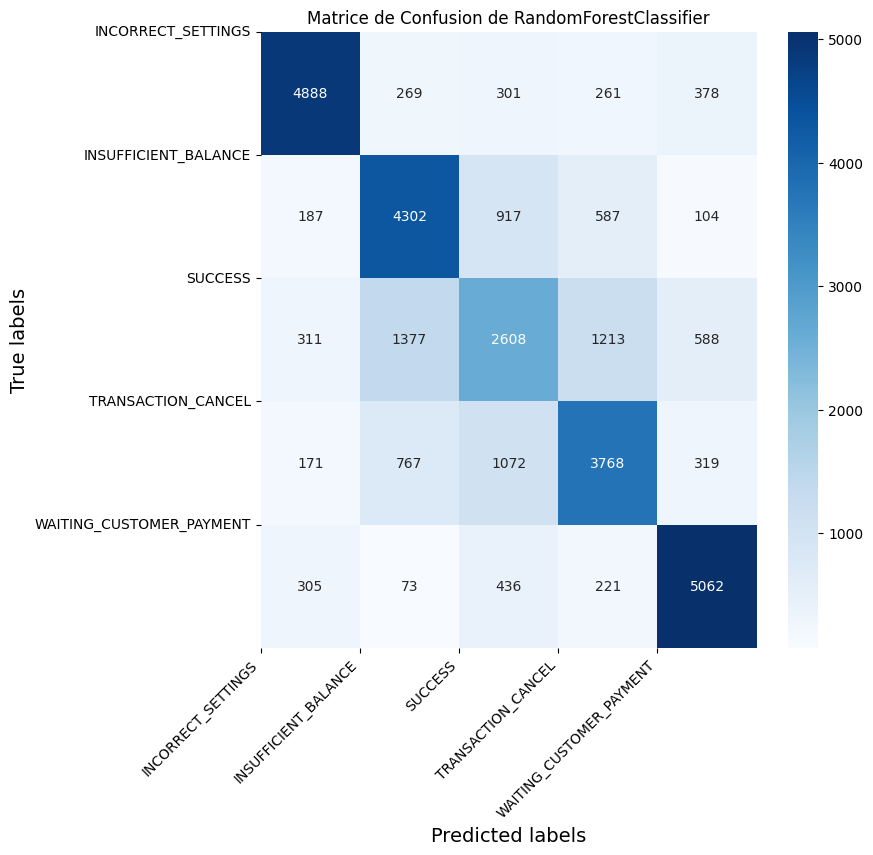

In [42]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une figure et un axe
fig, ax = plt.subplots(figsize=(8, 8))

# Afficher la matrice de confusion en utilisant une heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Définir les étiquettes des axes
ax.set_xlabel("Predicted labels", fontsize=14)
ax.set_ylabel("True labels", fontsize=14)

# Définir les noms des classes
class_names = ['INCORRECT_SETTINGS', 'INSUFFICIENT_BALANCE', 'SUCCESS', 'TRANSACTION_CANCEL', 'WAITING_CUSTOMER_PAYMENT']

# Ajouter les noms des classes aux axes
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')

# ajouter un titre
ax.set_title("Matrice de Confusion de RandomForestClassifier")

# Afficher le graphique
plt.show()

# GradientBoostingClassifier

In [44]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Créer un classificateur Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)

# Recherche d'hyperparamètres avec validation croisée
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour créer le modèle final
best_gb_classifier = grid_search.best_estimator_

# Entraîner le modèle final sur l'ensemble d'entraînement
best_gb_classifier.fit(X_train, y_train)

# Prédire les étiquettes des données de test
y_pred = best_gb_classifier.predict(X_test)

# Calculer l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle Gradient Boosting avec hyperparamètres optimisés:", accuracy)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

Meilleurs hyperparamètres: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
Exactitude du modèle Gradient Boosting avec hyperparamètres optimisés: 0.7120551090700344
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      6097
           1       0.64      0.67      0.66      6097
           2       0.57      0.69      0.62      6097
           3       0.66      0.40      0.50      6097
           4       0.81      0.92      0.86      6097

    accuracy                           0.71     30485
   macro avg       0.71      0.71      0.70     30485
weighted avg       0.71      0.71      0.70     30485



In [45]:
classification_df = pd.DataFrame(classification_rep).transpose()
classification_df

,precision,recall,f1-score,support
0,0.906766,0.936362,0.921327,6097.000000
1,0.664596,0.737084,0.698966,6097.000000
2,0.624867,0.577005,0.599983,6097.000000
3,0.643621,0.552731,0.594723,6097.000000
4,0.839659,0.903559,0.870438,6097.000000
accuracy,0.741348,0.741348,0.741348,0.741348
macro avg,0.735902,0.741348,0.737087,30485.000000
weighted avg,0.735902,0.741348,0.737087,30485.000000


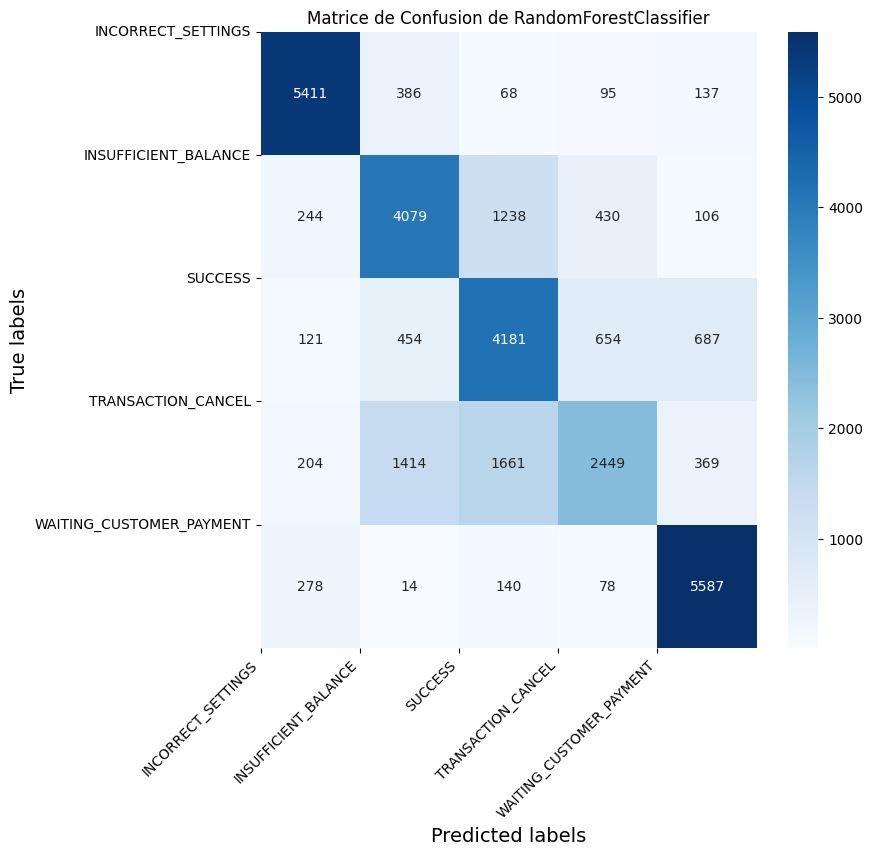

In [46]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une figure et un axe
fig, ax = plt.subplots(figsize=(8, 8))

# Afficher la matrice de confusion en utilisant une heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Définir les étiquettes des axes
ax.set_xlabel("Predicted labels", fontsize=14)
ax.set_ylabel("True labels", fontsize=14)

# Définir les noms des classes
class_names = ['INCORRECT_SETTINGS', 'INSUFFICIENT_BALANCE', 'SUCCESS', 'TRANSACTION_CANCEL', 'WAITING_CUSTOMER_PAYMENT']

# Ajouter les noms des classes aux axes
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')

# ajouter un titre
ax.set_title("Matrice de Confusion de RandomForestClassifier")

# Afficher le graphique
plt.show()

## CatBoostClassifier with smoted **data**

In [ ]:
# Initialiser le modèle CatBoostClassifier
model = CatBoostClassifier(iterations=150, learning_rate = 0.2, depth = 5 )

# Définir les colonnes catégorielles
cat_features = ['process', 'canal', 'country', 'event', 'browser', 'ip', 'agregator']

# Convertir les colonnes catégorielles en type catégoriel
X_train[cat_features] = X_train[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

# Créer un objet Pool pour les données d'entraînement et de test
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Entraîner le modèle
model.fit(train_pool)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(test_pool)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))


0:	learn: 1.4611949	total: 147ms	remaining: 21.9s
1:	learn: 1.3815079	total: 231ms	remaining: 17.1s
2:	learn: 1.3230964	total: 309ms	remaining: 15.1s
3:	learn: 1.2789531	total: 387ms	remaining: 14.1s
4:	learn: 1.2456889	total: 465ms	remaining: 13.5s
5:	learn: 1.2213511	total: 542ms	remaining: 13s
6:	learn: 1.1981156	total: 626ms	remaining: 12.8s
7:	learn: 1.1815448	total: 704ms	remaining: 12.5s
8:	learn: 1.1640645	total: 787ms	remaining: 12.3s
9:	learn: 1.1464891	total: 871ms	remaining: 12.2s
10:	learn: 1.1370635	total: 952ms	remaining: 12s
11:	learn: 1.1282438	total: 1.03s	remaining: 11.9s
12:	learn: 1.1187656	total: 1.12s	remaining: 11.8s
13:	learn: 1.1131953	total: 1.2s	remaining: 11.6s
14:	learn: 1.1082679	total: 1.27s	remaining: 11.5s
15:	learn: 1.1035970	total: 1.35s	remaining: 11.3s
16:	learn: 1.0956761	total: 1.43s	remaining: 11.2s
17:	learn: 1.0899226	total: 1.5s	remaining: 11s
18:	learn: 1.0835064	total: 1.58s	remaining: 10.9s
19:	learn: 1.0789217	total: 1.66s	remaining: 10.8

## CatBoostClassifier with auto_class_weights="Balanced"

In [ ]:
# Supposons que X contient vos variables explicatives et y votre variable cible
X = data_u.drop('statusCode', axis=1)  # Variables explicatives
y = data_u['statusCode']  # Variable cible

# Séparation en train (70%), test (20%) et validation (10%) en fonction de y (statusCode)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# Affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement (train) :", X_train.shape[0])
print("Taille de l'ensemble de test :", X_test.shape[0])
print("Taille de l'ensemble de validation :", X_val.shape[0])


Taille de l'ensemble d'entraînement (train) : 42585
Taille de l'ensemble de test : 12228
Taille de l'ensemble de validation : 6023


In [ ]:
# Convertir les colonnes catégorielles en type catégoriel
_train[cat_features] = X_train[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

# Créer un objet Pool pour les données d'entraînement et de test
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Définir les hyperparamètres à rechercher
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

# Créer un modèle CatBoostClassifier
model = CatBoostClassifier(iterations=100, task_type="GPU", devices='0:1', auto_class_weights="Balanced", random_state=42)

# Effectuer la recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_pool)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Faire des prédictions sur l'ensemble de test avec les meilleurs paramètres
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_pool)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

AttributeError: 'Pool' object has no attribute 'to_numpy'

In [ ]:
# Initialiser le modèle CatBoostClassifier
model = CatBoostClassifier(iterations=150, learning_rate = 0.2, depth = 5, auto_class_weights="Balanced" )

# Définir les colonnes catégorielles
cat_features = ['process', 'canal', 'country', 'event', 'browser', 'ip', 'agregator']

# Convertir les colonnes catégorielles en type catégoriel
X_train[cat_features] = X_train[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

# Créer un objet Pool pour les données d'entraînement et de test
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Entraîner le modèle
model.fit(train_pool)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(test_pool)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))


0:	learn: 1.4921110	total: 41.6ms	remaining: 6.2s
1:	learn: 1.4127007	total: 84ms	remaining: 6.22s
2:	learn: 1.3600030	total: 117ms	remaining: 5.75s
3:	learn: 1.3253538	total: 151ms	remaining: 5.5s
4:	learn: 1.2961212	total: 185ms	remaining: 5.37s
5:	learn: 1.2728177	total: 220ms	remaining: 5.28s
6:	learn: 1.2551983	total: 254ms	remaining: 5.18s
7:	learn: 1.2349210	total: 290ms	remaining: 5.14s
8:	learn: 1.2215797	total: 324ms	remaining: 5.08s
9:	learn: 1.2123123	total: 360ms	remaining: 5.03s
10:	learn: 1.2025287	total: 393ms	remaining: 4.97s
11:	learn: 1.1936934	total: 427ms	remaining: 4.9s
12:	learn: 1.1886603	total: 460ms	remaining: 4.85s
13:	learn: 1.1836651	total: 496ms	remaining: 4.82s
14:	learn: 1.1813216	total: 524ms	remaining: 4.72s
15:	learn: 1.1772195	total: 559ms	remaining: 4.68s
16:	learn: 1.1739043	total: 593ms	remaining: 4.64s
17:	learn: 1.1691462	total: 626ms	remaining: 4.59s
18:	learn: 1.1668335	total: 654ms	remaining: 4.51s
19:	learn: 1.1625399	total: 690ms	remaining:

# GaussianNB

In [ ]:
# Création du classificateur Naive Bayes gaussien
gnb = GaussianNB()

# Définition de la grille des hyperparamètres à optimiser
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Recherche par grille des meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Évaluation du modèle sur l'ensemble de test
best_gnb = grid_search.best_estimator_
y_pred = best_gnb.predict(X_test)

# Calculer l'exactitude
classification_rep = classification_report(y_test, y_pred)

print("\nClassification Report:\n", classification_rep)

Meilleurs hyperparamètres: {'var_smoothing': 1e-09}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6097
           1       0.04      0.01      0.02      6097
           2       0.67      0.00      0.00      6097
           3       0.22      0.98      0.36      6097
           4       0.62      0.10      0.17      6097

    accuracy                           0.22     30485
   macro avg       0.31      0.22      0.11     30485
weighted avg       0.31      0.22      0.11     30485



# MLPClassifier

In [ ]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'max_iter': [200, 400, 600]
}

# Créer un classificateur MLPClassifier
mlp_classifier = MLPClassifier(random_state=42)

# Recherche d'hyperparamètres avec validation croisée
grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour créer le modèle final
best_mlp_classifier = grid_search.best_estimator_

# Entraîner le modèle final sur l'ensemble d'entraînement
best_mlp_classifier.fit(X_train, y_train)

# Prédire les étiquettes des données de test
y_pred = best_mlp_classifier.predict(X_test)

# Calculer l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle MLPClassifier avec hyperparamètres optimisés:", accuracy)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

Meilleurs hyperparamètres: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}
Exactitude du modèle MLPClassifier avec hyperparamètres optimisés: 0.2
              precision    recall  f1-score   support

           0       0.20      1.00      0.33      6097
           1       0.00      0.00      0.00      6097
           2       0.00      0.00      0.00      6097
           3       0.00      0.00      0.00      6097
           4       0.00      0.00      0.00      6097

    accuracy                           0.20     30485
   macro avg       0.04      0.20      0.07     30485
weighted avg       0.04      0.20      0.07     30485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
